In [1]:
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

class Helper(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = Helper.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations
        train_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms

    @staticmethod
    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    @staticmethod
    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std

    # First step
    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = Helper.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = Helper.get_test_transforms(mean, std)
        if test_transforms is None:
            test_transforms = Helper.get_test_transforms(mean, std)
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    def view_images(self, path='./data', num_of_images=60, display_log=True):
        # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
        print("The initial stastics:")
        train, test = self.get_train_test_data_set(path=path, display_log=True)
        train_data = train.train_data
        train_data = train.transform(train_data.numpy())

        print('Image data stastics')
        print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
        print(' - Tensor Shape:', train.train_data.size())
        print(' - min:', torch.min(train_data))
        print(' - max:', torch.max(train_data))
        print(' - mean:', torch.mean(train_data))
        print(' - std:', torch.std(train_data))
        print(' - var:', torch.var(train_data))

        train_loader, test_loader = self.get_data_loader(train, test, batch_size=128)
        dataiter = iter(train_loader)
        images, labels = dataiter.next()

        print(images.shape)
        print(labels.shape)

        plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
        print("")
        self.view_defined_images(images, num_of_images)


    def view_defined_images(self, images, num_of_images):
        figure = plt.figure()
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))


    # second step
    def train_test_model(self, model_obj, EPOCHS=20, batch_size=128, path='./data', optimizer=None):
        # Train and test our model
        device = Helper.get_device()
        model = model_obj.to(device)
        if optimizer is None:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    @staticmethod
    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff

    def display_plot(self):
        try:
            fig, axs = plt.subplots(2,2,figsize=(15,10))
            axs[0, 0].plot(self.train_losses)
            axs[0, 0].set_title("Training Loss")
            axs[1, 0].plot(self.train_acc)
            axs[1, 0].set_title("Training Accuracy")
            axs[0, 1].plot(self.test_losses)
            axs[0, 1].set_title("Test Loss")
            axs[1, 1].plot(self.test_acc)
            axs[1, 1].set_title("Test Accuracy")
            print('Train loss: ',self.train_min_loss)
            print('Test loss: ',self.test_losses)
            print("Difference in loss : ", Helper.calculate_diff(self.train_min_loss, self.test_losses))
            print('Train Accuracy: ',self.train_max_acc)
            print('Test Accuracy: ',self.test_acc)
            print("Difference in Accuracy : ", Helper.calculate_diff(self.train_max_acc, self.test_acc))
        except Exception as e:
            print("First train the model")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            print(str(e))
            pass

In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
------------------------------

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
Image data stastics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4237)
 - max: tensor(2.8219)
 - mean: tensor(0.0016)
 - std: tensor(1.0000)
 - var: tensor(1.0000)
CUDA Available? True
torch.Size([128, 1, 28, 28])
torch.Size([128])



  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.10697311908006668 Batch_id=468 Accuracy=84.65: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Train Set: Train Loss=0.04308191314339638 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:19<00:00, 24.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9833/10000 (98.33%)

EPOCH: 3


Train Set: Train Loss=0.03999421373009682 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Train Set: Train Loss=0.008621658198535442 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Train Set: Train Loss=0.015313406474888325 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:19<00:00, 24.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Train Set: Train Loss=0.003619035007432103 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Train Set: Train Loss=0.0017806589603424072 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:19<00:00, 24.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Train Set: Train Loss=0.009838610887527466 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:19<00:00, 24.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Train Set: Train Loss=0.002654383657500148 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:19<00:00, 24.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Train Set: Train Loss=0.011859267950057983 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Train Set: Train Loss=0.0019473135471343994 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Train Set: Train Loss=0.0035751659888774157 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Train Set: Train Loss=0.0003587007522583008 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Train Set: Train Loss=0.00037980079650878906 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Train Set: Train Loss=0.0004057983460370451 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Train Set: Train Loss=0.0010309318313375115 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Train Set: Train Loss=0.000958045304287225 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:19<00:00, 24.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Train Set: Train Loss=1.637140849197749e-05 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Train Set: Train Loss=1.3321638107299805e-05 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Train Set: Train Loss=1.1026859283447266e-05 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]



Test set: Average loss: 0.0321, Accuracy: 9929/10000 (99.29%)

Train loss:  [0.10697311908006668, 0.04308191314339638, 0.03999421373009682, 0.008621658198535442, 0.015313406474888325, 0.003619035007432103, 0.0017806589603424072, 0.009838610887527466, 0.002654383657500148, 0.011859267950057983, 0.0019473135471343994, 0.0035751659888774157, 0.0003587007522583008, 0.00037980079650878906, 0.0004057983460370451, 0.0010309318313375115, 0.000958045304287225, 1.637140849197749e-05, 1.3321638107299805e-05, 1.1026859283447266e-05]
Test loss:  [0.06255048999786376, 0.052252521467208865, 0.031731178855896, 0.03449487645626068, 0.02607515971660614, 0.0282976508975029, 0.029362699460983275, 0.029459399080276488, 0.023041244411468507, 0.03021694531440735, 0.027116591000556946, 0.033027761793136594, 0.027343254899978638, 0.027734262490272523, 0.03026121234893799, 0.032482225322723386, 0.03236603555679321, 0.031767498850822445, 0.034939744925498964, 0.03210337920188904]
Difference in loss :  [0.044422

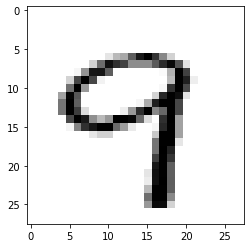

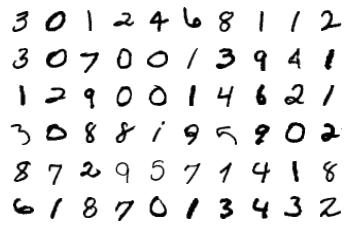

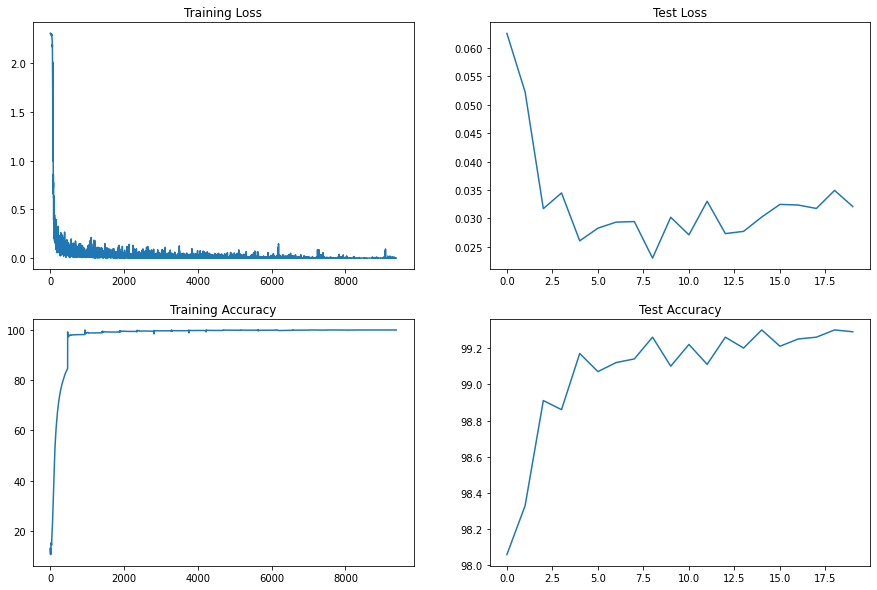

In [3]:
with Helper() as helper_obj:
  obj1 = Net1()
  helper_obj.display_summary(obj1, 28)
  helper_obj.view_images()
  helper_obj.train_test_model(obj1, EPOCHS=20)
  helper_obj.display_plot()